# Bayesian inference

In [1]:
import sys, os
import logging
import numpy as np
from scipy.stats import uniform, norm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPatch
%matplotlib inline

sys.path.append('../')
import paper_settings
from simulation.units import *
from simulation.prior import get_grid
from inference.bayes import Posterior

In [2]:
paper_settings.setup()

## Setup

In [19]:
n_samples = list(range(0,100)) + list(range(100,1000, 10))

In [20]:
filename = "calibrated_alices_full_sgd1e2_grid"

In [24]:
def narrow_prior(thetas):
    f_sub = thetas[:,0]
    beta = thetas[:,1]
    
    return uniform(0.001, 0.199).pdf(f_sub).flatten() * norm(-1.9, 0.1).pdf(beta).flatten()

## Data

In [21]:
n_max = n_samples[-1]
llr = np.load("../data/results/llr_{}.npy".format(filename))[:,:n_max]

In [22]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## Calculate posteriors on f_sub, beta

In [41]:
posteriors = []

for n in n_samples:
    if n == 0:
        posteriors.append(narrow_prior(theta_grid))
    else:
        bayes = Posterior(llr[:,:n], theta_grid)
        posteriors.append(bayes.posterior_based_on_expected_llr(n, narrow_prior))
                          
posteriors = np.array(posteriors)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


## Drawing from posterior

In [42]:
def draw_fsub_beta(posterior):
    posterior /= np.sum(posterior)
    
    # Draw bin
    i_bin = np.random.choice(list(range(625)), p=posterior)
    
    # Draw f_sub and theta uniformly within bin
    f_sub = theta_grid[i_bin][0] + (f_sub_1d[1] - f_sub_1d[0]) * (np.random.random() - 0.5)
    beta = theta_grid[i_bin][1] + (beta_edges[1] - beta_edges[0]) * (np.random.random() - 0.5)
    
    return f_sub, beta

## SHMF

In [43]:
def M_200_sigma_v(sigma_v, scatter=False):
    """
    Relate central velocity dispersion to halo virial mass
    From https://arxiv.org/pdf/1804.04492.pdf
    """
    a = 0.09
    b = 3.48
    if scatter:
        sigma_log10_M_200 = 0.13  # Lognormal scatter
        log10_M_200 = np.random.normal(a + b * np.log10(sigma_v / (100 * Kmps)), sigma_log10_M_200)
    else:
        log10_M_200 = a + b * np.log10(sigma_v / (100 * Kmps))
    return (10 ** log10_M_200) * 1e12 * M_s

In [44]:
def shmf_by_mhost(fsub, beta, msubs):
    """ Evaluates dn / dm for a given set of m (msubs)"""
    
    sigma_v = np.random.normal(225, 50)
    mhost = M_200_sigma_v(sigma_v * Kmps)
    
    m_min_calib=1e6 * M_s
    m_max_calib=0.01 * mhost
    M_0=M_MW
    m_0 = 1.e9 * M_s
                
    alpha = fsub * ((2 + beta) * M_0 * m_0 ** beta) / (m_max_calib ** (beta + 2) - m_min_calib ** (beta + 2))
    
    return np.where(msubs > m_max_calib, 0., alpha * (mhost / M_0) * (msubs / m_0)**beta / mhost)
                

## Generate SHMF data

In [45]:
n_realizations = 100
fsub_true, beta_true = 0.05, -1.9
msubs = np.geomspace(1.e7, 1e12, 50) * M_s

In [46]:
def mean_and_ci(samples, levels=[0.68, 0.95]):
    mean = np.mean(samples, axis=0)
    all_down = [np.quantile(samples, (1. - level)/2, axis=0) for level in levels]
    all_up = [np.quantile(samples, 1. - (1. - level)/2, axis=0) for level in levels]
    all_cis = np.array([all_down, all_up])

    return mean, all_cis

In [47]:
shmfs = []
for _ in range(n_realizations):
    shmfs.append(shmf_by_mhost(fsub_true, beta_true, msubs))
shmf_true, _ = mean_and_ci(np.asarray(shmfs), levels=[])    # (n_datapoints)

In [56]:
shmf_posteriors = []
shmf_posterior_cis = []

for posterior_ in posteriors:
    shmfs = []
    for _ in range(n_realizations):
        fsub_, beta_ = draw_fsub_beta(posterior_)
        shmfs.append(shmf_by_mhost(fsub_, beta_, msubs))
        
    mean, ci = mean_and_ci(np.asarray(shmfs), levels=[0.68, 0.95])
    
    shmf_posteriors.append(mean)
    shmf_posterior_cis.append(ci)
    
shmf_posteriors = np.asarray(shmf_posteriors)  # (n_frames, n_datapoints)
shmf_posterior_cis = np.asarray(shmf_posterior_cis)  # (n_frames, 2, n_bands, n_datapoints)

## Plot

In [50]:
x = 1./M_s * msubs
y_mult = msubs**2

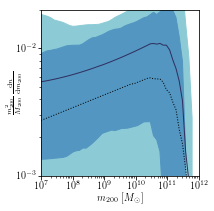

In [61]:
fig = paper_settings.figure()
ax = plt.gca()
 
fillpost2 = plt.fill_between(x, y_mult * shmf_posterior_cis[0,0, 1], msubs**2 * shmf_posterior_cis[0,1, 1], facecolor=paper_settings.COLOR_FIX, edgecolor=paper_settings.COLOR_FIX)
fillpost1 = plt.fill_between(x, y_mult * shmf_posterior_cis[0,0, 0], msubs**2 * shmf_posterior_cis[0,1, 0], facecolor=paper_settings.COLOR_ALIGN, edgecolor=paper_settings.COLOR_ALIGN)
lpost, = plt.plot(x, y_mult * shmf_posteriors[0], alpha=1., c=paper_settings.COLOR_FULL, lw=1.0, label="Posterior")
ltrue, = plt.plot(x, y_mult * shmf_true, alpha=1., c="black", lw=1.0, ls=":", label="True SHMF")

# ax.add_patch(matplotlib.patches.Rectangle(xy=(1.93e7,1.147e-2), width=6.4e7, height=0.2e-2, facecolor=paper_settings.COLOR_FIX, edgecolor=paper_settings.COLOR_FIX))
# ax.add_patch(matplotlib.patches.Rectangle(xy=(1.93e7,1.195e-2), width=6.4e7, height=0.09e-2, facecolor=paper_settings.COLOR_ALIGN, edgecolor=paper_settings.COLOR_ALIGN))
# ax.legend(
#     [ltrue, lpost],
#     ["True SHMF", "Posterior"],
#     loc=2,
#     frameon=False
# )

plt.xlabel(r"$m_{200}$ [$M_{\odot}$]")
ax.xaxis.set_label_coords(0.5, -0.11)
plt.ylabel(r"$\frac {m_{200}^2}{M_{200}} \frac{\mathrm{d}n}{\mathrm{d}m_{200}}$")
ax.yaxis.set_label_coords(-0.115, 0.5)
ax.yaxis.set_ticks([0.,0.005,0.010])
ax.yaxis.set_tick_params(pad=1)

plt.xscale("log")
plt.xlim(1.e7, 1.e12)
plt.yscale("log")
plt.ylim(0.001,0.02)
#plt.ylim(0., None)
    
plt.savefig("../figures/shmf.pdf", dpi=300)
